# Hypersion projest

- Jacopo Umberto Verga

## Final annotation

Annotation of celltypes and annotation of functional markers (when needed)

In [1]:
import squidpy as sq
import scanpy as sc
import anndata as ad
import os
import sys
import pandas as pd
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import time
import gc
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings("ignore")

In [2]:
def set_thresholds(adata,gene):
    gene_exp=sc.get.obs_df(adata, keys=gene,layer='exprs')
    
    mu = np.mean(gene_exp)
    sigma = np.std(gene_exp)
    low_threshold = mu - sigma
    high_threshold = mu + sigma

    return {'high':high_threshold,'low':low_threshold}



def filter_cells(adata, celltype,column='minor_cell_type'):
    adata_tmp = adata[adata.obs[column]==celltype]
    return adata_tmp

def create_mat(adata_tmp, features_oi):
    df = pd.DataFrame(adata_tmp.layers['exprs'], index=adata_tmp.obs_names, columns=adata_tmp.var_names)
    df=df[features_oi]
    return df.values
    
def BIC(mat):
    np.random.seed(12345)
    n_components_range = range(2, 11)
    covariance_types = ['full', 'tied', 'diag', 'spherical']
    
    bic_scores = {}
    
    for covariance_type in covariance_types:
        bic_scores[covariance_type] = []
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=12345,max_iter=99999)
            gmm.fit(mat)
            bic = gmm.bic(mat)
            bic_scores[covariance_type].append(bic)
    best_covariance_type=pd.DataFrame(bic_scores).min().idxmin()
    best_n_components=pd.DataFrame(bic_scores).idxmin().loc[best_covariance_type]+2
    return best_covariance_type,best_n_components

def cluster(mat, best_covariance_type,best_n_components):
    best_gmm = GaussianMixture(n_components=best_n_components, covariance_type=best_covariance_type, random_state=12345,max_iter=99999)
    best_gmm.fit(mat)
    clusters = best_gmm.predict(mat)
    return clusters,best_gmm


def cluster_cells(adata, celltype,features_oi,column='minor_cell_type'):
    adata_tmp=filter_cells(adata, celltype,column)
    mat=create_mat(adata_tmp,features_oi)
    # if mat.shape[1] ==1:
    #     mat=mat.reshape(-1,1)
    best_covariance_type,best_n_components=BIC(mat)
    clusters,best_gmm=cluster(mat, best_covariance_type,best_n_components)
    adata_tmp.obs['clusters'] = clusters
    return best_gmm, adata_tmp

def plot_heatmap(best_gmm,celltype,features_oi):
    means=pd.DataFrame(best_gmm.means_,columns=features_oi)

    plt.figure(figsize=(5, 4))
    sns.heatmap(means, annot=True)
    plt.suptitle(celltype)
    plt.tight_layout()
    plt.show()
    return means

    
def update_labels(adata_tmp,adata, cluster_map, obs_col):
    for cluster, custom_name in cluster_map.items():
        cluster_cells = adata_tmp.obs['clusters'] == int(cluster)
        adata_tmp.obs.loc[cluster_cells, obs_col] = custom_name
        
    adata.obs.loc[adata_tmp.obs.index, obs_col] = adata_tmp.obs[obs_col]
    return adata


def do_cluster_map(df, gene, thresholds,celltype):
    cluster_map={}
    # Iterate through each row (cluster) in the DataFrame
    for cluster, row in df.iterrows():
        value = row[gene]
        
        # Determine the classification based on thresholds
        if value >= thresholds[gene]['high']:
            classification = 'high'
        elif value < thresholds[gene]['low']:
            classification = 'low'
        else:
            classification = 'dim'
        
        # Store the classification in the result dictionary
        cluster_map[cluster] = f"{gene}-{classification} {celltype}"

    return cluster_map


from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
from statsmodels.stats.multitest import multipletests

def test_marker_expression(df, group_col, markers, alpha=0.05):
    results = {}

    # Split the DataFrame into the two groups
    groups = df[group_col].unique()
    if len(groups) != 2:
        raise ValueError("There should be exactly 2 groups in the group column.")

    group1 = df[df[group_col] == groups[0]]
    group2 = df[df[group_col] == groups[1]]

    for marker in markers:
        result = {}

        
        # Normality test (Shapiro-Wilk)
        stat1, p1 = shapiro(group1[marker])
        stat2, p2 = shapiro(group2[marker])
        result['normality_p_group1'] = p1
        result['normality_p_group2'] = p2

        # Equal variance test (Levene's test)
        stat_levene, p_levene = levene(group1[marker], group2[marker])
        result['equal_var_p'] = p_levene
        

        # Determine which test to run based on normality and equal variance
        if p1 > alpha and p2 > alpha and p_levene > alpha:
            # Both groups are normally distributed and have equal variances
            stat, p = ttest_ind(group1[marker], group2[marker],equal_var=True)
            test = 't-test'
        elif p1 > alpha and p2 > alpha and p_levene < alpha:
            # Both groups are normally distributed but not have equal variances
            stat, p = ttest_ind(group1[marker], group2[marker],equal_var=True)
            test = 't-test'
        else:
            # At least one group is not normally distributed or variances are not equal
            stat, p = mannwhitneyu(group1[marker], group2[marker])
            test = 'Wilcoxon rank-sum test'
   
        result['test'] = test
        result['statistic'] = stat
        result['p_value'] = p
        results[marker] = result

    return results#pd.DataFrame(results).T


def add_significance_annotations(ax, results, column='p_value',alpha=0.05):
    for text in ax.get_xticklabels():
        x,y=text.get_position()
        marker=text.get_text()
        if results.loc[marker,column] < alpha:
            y_max = df_melt[df_melt['variable'] == marker]['value'].max()
            y = y_max + (y_max * 0.05)  # Adjust y position for the annotation

            ax.annotate(f"p={results.loc[marker,column]:.3e}", 
                        xy=(x, y), 
                        xycoords='data',
                        ha='center', va='bottom')

In [3]:
adata=sc.read('../data/non_denoised/spe_minor_celltypes_final.h5ad')
adata.obs['major_cell_type']=adata.obs['major_cell_type'].astype(str)
adata.obs['medium_cell_type']=adata.obs['medium_cell_type'].astype(str)
adata.obs['minor_cell_type']=adata.obs['minor_cell_type'].astype(str)
adata

AnnData object with n_obs × n_vars = 505794 × 36
    obs: 'area', 'centroid-0', 'centroid-1', 'axis_major_length', 'axis_minor_length', 'eccentricity', 'Cell_ID', 'library_id', 'sample_id', 'ObjectNumber', 'width_px', 'height_px', 'major_celltype', 'major_cell_type', 'minor_cell_type', 'Ki-67_minor_cell_type', 'PD-L1_minor_cell_type', 'PD-1_minor_cell_type', 'pSTAT1_minor_cell_type', 'TIM-3_minor_cell_type', 'tissue_id', 'slide_id', 'timepoint', 'patient_n', 'DFCI_id', 'MRN', 'medium_cell_type', 'Ki-67_medium_cell_type', 'PD-L1_medium_cell_type', 'PD-1_medium_cell_type', 'pSTAT1_medium_cell_type', 'TIM-3_medium_cell_type'
    uns: 'spatial'
    obsm: 'PCA', 'UMAP_mnnCorrected', 'fastMNN', 'spatial'
    layers: 'exprs', 'logcounts'

In [4]:
adata.obs['functional_minor_cell_type'] = adata.obs['minor_cell_type'].copy()

### Endothelial cells:

Standardize with “Endothelial cells (ECs)”. (minor, median = same)

In [5]:
dict_map={'Endothelial':'ECs'}
adata.obs['major_cell_type']=adata.obs['major_cell_type'].replace(dict_map)
adata.obs['medium_cell_type']=adata.obs['medium_cell_type'].replace(dict_map)
adata.obs['minor_cell_type']=adata.obs['minor_cell_type'].replace(dict_map)
adata.obs['functional_minor_cell_type']=adata.obs['functional_minor_cell_type'].replace(dict_map)

### Megakaryocytes
Standardize with “Megakaryocytes (MKs)”. (minor, median = same)


In [6]:
dict_map={'Megakaryocytes':'MKs'}
adata.obs['major_cell_type']=adata.obs['major_cell_type'].replace(dict_map)
adata.obs['medium_cell_type']=adata.obs['medium_cell_type'].replace(dict_map)
adata.obs['minor_cell_type']=adata.obs['minor_cell_type'].replace(dict_map)
adata.obs['functional_minor_cell_type']=adata.obs['functional_minor_cell_type'].replace(dict_map)

### B cells

- Median level : “B cells” = B, B mem, B unk
- Minor level 
    - B mem > Standardize with “Memory B cells (MBCs)”. We can consider them as “class switched B cell.”
    - B & B unk > Unify into “B cells”.B unk can be “activated B cells” (PMID: 25785995).
                                  We can decide either “unify” or “rename B unk”.
                                  Given the limited data to support the importance of B unk in the data
                                  so far, I would prefer to unify them to make our annotation simple.
                                  And it’s ok to keep “activated B cells” under “B cells” just in case
                                  It’ll work when we find some interesting things in B cells

In [7]:
dict_map={'B':'B cells'}
adata.obs['major_cell_type']=adata.obs['major_cell_type'].replace(dict_map)
adata.obs['medium_cell_type']=adata.obs['medium_cell_type'].replace(dict_map)

In [8]:
dict_map={'B':'B cells','B unk':'B cells', 'B mem':'MBCs'}
adata.obs['minor_cell_type']=adata.obs['minor_cell_type'].replace(dict_map)
adata.obs['functional_minor_cell_type']=adata.obs['functional_minor_cell_type'].replace(dict_map)

### NK cells



- Median level: NK cells = CD56 dim NK, CD56 bright NK
- Minor level:  “CD56 dim NK”, “CD56 bright NK” > No change.
    - dim = cytotoxic (ADCC), 
    - bright = cytokine producing (pro-inflammatory) 
- Functional level
    - Potentially, ”pSTAT1+ CD56 dim NK”, “pSTAT1+ CD56 bright NK”
                              I would prefer to consider pSTAT1 high = pSTAT1+, others = pSTAT-.
                              It doesn’t always the exact same population but I think we can consider
                              these pSTAT1+ group as IFN-responsive NK cells which is well
                              documented at scRNAseq work in the field of myeloma. If NK shows
                              interesting signal, let’s revisit and add this layer. 

In [9]:
dict_map={'NK':'NK cells'}
adata.obs['major_cell_type']=adata.obs['major_cell_type'].replace(dict_map)
adata.obs['medium_cell_type']=adata.obs['medium_cell_type'].replace(dict_map)

### pSTAT1 NK cells
#### CD56 dim

In [10]:
celltype='CD56 dim NK'
best_gmm,adata_tmp=cluster_cells(adata,celltype,['pSTAT1'])

In [11]:
thresholds={}
gene='pSTAT1'
thresholds[gene]=set_thresholds(adata_tmp,gene)

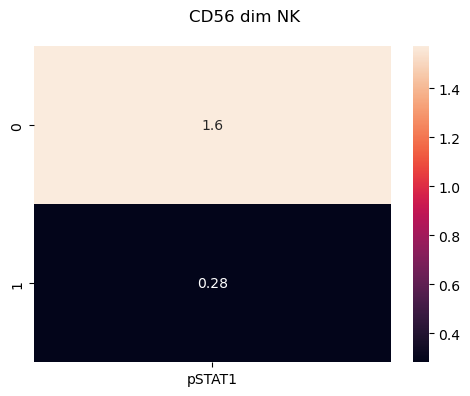

In [12]:
means=plot_heatmap(best_gmm, celltype,[gene])

In [13]:
cluster_map={0: 'pSTAT1- CD56 dim NK', 1: 'pSTAT1+ CD56 dim NK'}

In [14]:
adata=update_labels(adata_tmp,adata, cluster_map, obs_col='functional_minor_cell_type')
del adata_tmp
gc.collect()
time.sleep(1)

#### CD56 bright

In [15]:
celltype='CD56 bright NK'
best_gmm,adata_tmp=cluster_cells(adata,celltype,['pSTAT1'])

In [16]:
thresholds={}
gene='pSTAT1'
thresholds[gene]=set_thresholds(adata_tmp,gene)

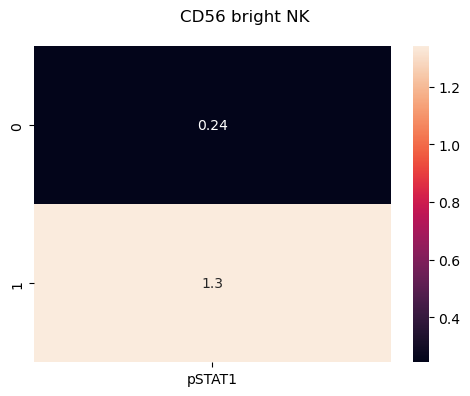

In [17]:
means=plot_heatmap(best_gmm, celltype,[gene])

In [18]:
cluster_map={0: 'pSTAT1- CD56 bright NK', 1: 'pSTAT1+ CD56 bright NK'}

In [19]:
adata=update_labels(adata_tmp,adata, cluster_map, obs_col='functional_minor_cell_type')
del adata_tmp
gc.collect()
time.sleep(1)

### Macrophages


- Same for median and minor. (ref. https://doi.org/10.1016/j.it.2022.04.008)
    - Macrophages-CD163 neg > “M1-like macrophages (M1-like Mφ)”
    - Macrophages-hla & Macrophages > “M2-like macrophages (M2-like Mφ)”
- Functional level 
    - We will use them to validate M2-like = immunosuppressive. 
                     If preferred (or if we see some contradictions in our result), consider labeling 
                     [HLA-DR and (PD-L1 and/or TIM-3)] high subpopulation as Reg-TAM-like,
                     and (PD-L1 and pSTAT1) high subpopulation as IFN-TAM-like, which is also
                     functionally immunosuppressive, although they are M1-like.

In [20]:
dict_map={'M1 macrophages':'M1-like M$\phi$','M2 macrophages':'M2-like M$\phi$'}
adata.obs['medium_cell_type']=adata.obs['medium_cell_type'].replace(dict_map)


In [21]:
dict_map={'Macrophages-CD163 neg':'M1-like M$\phi$',
          'Macrophages':'M2-like M$\phi$',
          'Macrophages-hla':'M2-like M$\phi$'}
adata.obs['minor_cell_type']=adata.obs['minor_cell_type'].replace(dict_map)
adata.obs['functional_minor_cell_type']=adata.obs['functional_minor_cell_type'].replace(dict_map)

In [22]:
adata_m=adata[adata.obs['medium_cell_type'].isin(['M1-like M$\phi$','M2-like M$\phi$'])]

In [23]:
functional_markers = ['TIM-3', 'PD-L1', 'Ki-67', 'pSTAT1']
df=sc.get.obs_df(adata_m, keys=functional_markers,layer='exprs')
df=pd.concat([df, adata_m.obs[['medium_cell_type']]], axis=1)

In [24]:
df_melt=pd.melt(df, value_vars=['TIM-3','PD-L1','pSTAT1','Ki-67'],
                         id_vars=['medium_cell_type'])

In [25]:
results=pd.DataFrame(test_marker_expression(df, 'medium_cell_type', functional_markers, alpha=0.05)).T
results['adj.p_value']=multipletests(results['p_value'].astype(float).to_numpy(),method='bonferroni')[1]


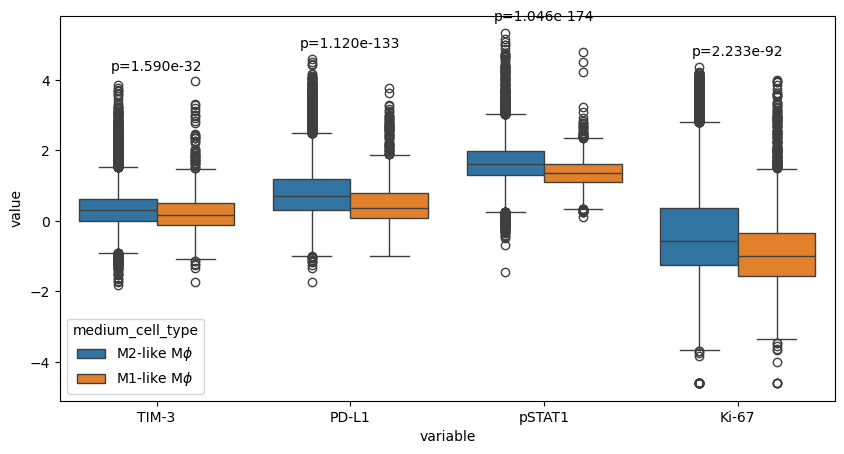

In [26]:
# Plot with seaborn
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df_melt, x='variable', y='value', hue='medium_cell_type')

# Add significance annotations
add_significance_annotations(ax, results, column='adj.p_value')
plt.show()


### Monocytes


- Median level:
    - “Monocytes” =classical, intermediate, non-classical.
    - ”MoDC” = DC
- Minor level (ref https://doi.org/10.1016/j.it.2023.10.005)
    - Non Classical Monocytes > Standardize with “Nonclassical monocytes”.
    - Intermediate Monocytes > “Intermediate monocytes”.
    - Classical Monocytes > “Classical monocytes”. 
    - DC > Standardize with “Monocyte-derived dendritic cells (moDCs)”.Considering the expression of CD14/CD16/CD4, I would like to consider
                           them as monocyte-derived dendritic cells (MoDCs). MoDCs are 
                           pro-inflammatory, serving for antigen-presentation to T cells. Classical 
                           = phagocytosis, intermediate = antigen presentation, cytokine secretion, 
                           non-classical = complement and Fc gamma-mediated phagocytosi

In [27]:
adata.obs.loc[adata.obs['minor_cell_type']=='DC', 'medium_cell_type'] = 'MoDC'

In [28]:
dict_map={'Non Classical Monocytes':'Nonclassical monocytes',
          'Classical Monocytes':'Classical monocytes',
          'Intermediate Monocytes':'Intermediate monocytes',
          'DC':'MoDC'}
adata.obs['minor_cell_type']=adata.obs['minor_cell_type'].replace(dict_map)
adata.obs['functional_minor_cell_type']=adata.obs['functional_minor_cell_type'].replace(dict_map)

### Myeloma

- Median=Minor level: “Myeloma”
- Functional level (ref https://doi.org/10.1111/ejh.14016) no additional labeling.
    - Ki-67 positive > “Proliferative myeloma”
                        There are various reports regarding PD-L1 expression on myeloma. In this 
                        analysis, I'd like to just check if there's a difference in PD-L1 expression 
                        between myeloma cells classified as SC/CN myeloma-T and those 
                        classified as SC/CN myeloma-infiltrated, for example.
                        Similarly, as for Ki-67, instead of subclassifying them as proliferative, it 
                        might be appropriate to limit our discussion to broad topics such as 
                        whether Ki-67 expression is high or low in SC/CN myeloma compared to
                        others. Therefore, in this analysis, we won't conduct detailed labeling.

In [29]:
celltype='Myeloma'
best_gmm,adata_tmp=cluster_cells(adata,celltype,['PD-L1','Ki-67'],column='medium_cell_type')

In [30]:
thresholds={}
for gene in ['PD-L1','Ki-67']:
    thresholds[gene]=set_thresholds(adata_tmp,gene)

In [31]:
thresholds

{'PD-L1': {'high': 1.322684534329999, 'low': -0.09034766442563091},
 'Ki-67': {'high': -0.023725012421963454, 'low': -2.526311624800967}}

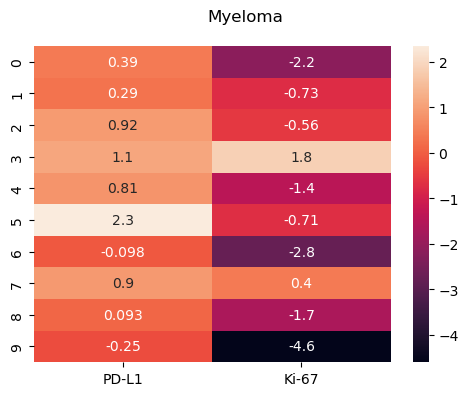

In [32]:
means=plot_heatmap(best_gmm, celltype,['PD-L1','Ki-67'])

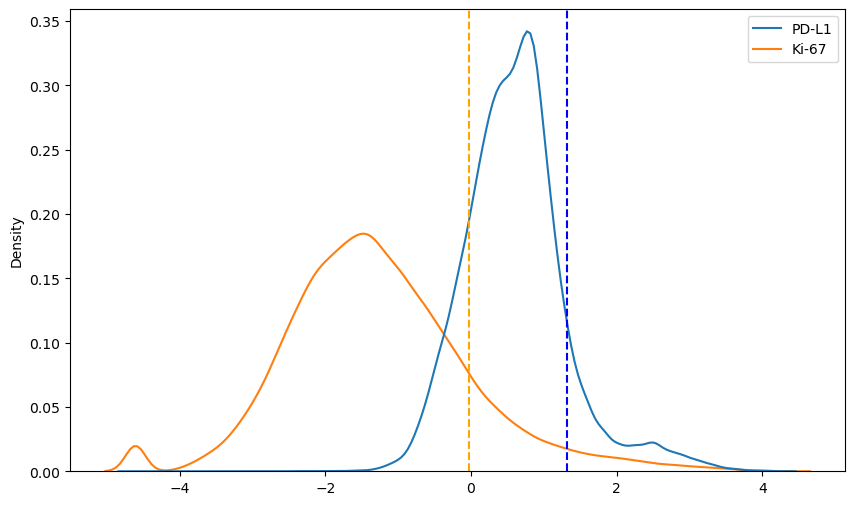

In [33]:
plt.figure(figsize=(10,6))
sns.kdeplot(sc.get.obs_df(adata_tmp, keys=['PD-L1','Ki-67'],layer='exprs'))
plt.axvline(thresholds['PD-L1']['high'],0,1,color='blue',linestyle='--')
plt.axvline(thresholds['Ki-67']['high'],0,1,color='orange',linestyle='--')
plt.show()

In [34]:
cluster_map={5: 'PD-L1+ Myeloma',
             3: 'Ki-67+ Myeloma',
             7: 'Ki-67+ Myeloma'}
adata=update_labels(adata_tmp,adata, cluster_map, obs_col='functional_minor_cell_type')
del adata_tmp
gc.collect()
time.sleep(1)

### MDSCs

- Median=Minor level: “MDSCs” = other myeloid
- Functional level, I don’t add any further layer here.
                          Other myeloid are positive for CD11b, CD68, weakly positive for CD45, 
                          HLA-DR, and CD14. I prefer to specify them as MDSCs. Probably, more
                          likely to be PMN-MDSCs given the dim or no expression of CD14.
                          But I don’t think we have enough evidence to label them as PMN.
              (ref https://doi.org/10.1038/s41577-020-00490-y, https://doi.org/10.3389/fimmu.2022.1102471)
                          

In [35]:
dict_map={'Other myeloid':'MDSCs'}
adata.obs['minor_cell_type']=adata.obs['minor_cell_type'].replace(dict_map)
adata.obs['medium_cell_type']=adata.obs['medium_cell_type'].replace(dict_map)
adata.obs['functional_minor_cell_type']=adata.obs['functional_minor_cell_type'].replace(dict_map)

### T cells


- Median/functional level: 
    - “Tnaive” = CD4 Tnaive, CD8 Tnaive
    - “CD4 Tmem” = CD4 Tcm, CD4 Tem, CD4 Temra, CD4 Th17, CD4 unclassified
    - “CD8 GZMB+ Tmem” = CD8 Tem-GZMB, CD8 Temra-GZMB 
    - “CD8 Tmem” = CD8 Tcm, CD8 Tem, CD8, Temra
    - “CD4 Tex” = new subsets, part of above
    - “CD8 Tex” = new subsets, part of above
    - “Treg” = CD4 Treg
- Minor/functional level: 
    - “CD4 Tnaive” = CD4 Tnaive, 
    - ”CD8 Tnaive” = CD8 Tnaive
    - “Th17 CD4 Tmem” = CD4 Th17, 
    - “Non Th17 CD4 Tmem” = CD4 Tcm, CD4Tem, CD4 Temra, CD4 unclassified  
    - “CD8+ GZMB Tmem” = CD8 Tem-GZMB, CD8 Temra-GZMB
    - “CD8+ Tmem” = CD8 Tcm, CD8 Tem, CD8 Temra
    - “CD4+ Tex” = new subsets, part of above
    - “CD8+ Tex” = new subsets, part of above
    - “Treg” = CD4 Treg
 

To define CD4 Tex, we combined all CD4 subsets of cells except for CD4 Tnaive and Treg 
and performed re-clustering using TIM-3 and PD-1. Then, we labelled CD4 Tex to cells 
expressing both TIM-3/PD-1 while put CD4 Tmem for others. We did the similar approach
to define CD8 Tex as well. In this case, we used GZMB, TIM-3, and PD-1 to define
CD8 GZMB+ Tmem, CD8 Tmem, and CD8 Tex

In [36]:
adata.obs.loc[adata.obs['medium_cell_type']=='CD4 T', 'medium_cell_type'] = adata.obs.loc[adata.obs['medium_cell_type'] == 'CD4 T', 'minor_cell_type']
adata.obs.loc[adata.obs['medium_cell_type']=='CD8 T', 'medium_cell_type'] = adata.obs.loc[adata.obs['medium_cell_type'] == 'CD8 T', 'minor_cell_type']


In [37]:
dict_map={'CD4 Tnaive':'Tnaive',
          'CD8 Tnaive':'Tnaive',
          'CD4 Tcm':'CD4 Tmem',
          'CD4 Tem':'CD4 Tmem',
          'CD4 Temra':'CD4 Tmem',
          'CD4 Th17':'CD4 Tmem',
          'CD4 Tunspecified':'CD4 Tmem',
          'CD8 Tem-GZMB':'CD8 Tmem',
          'CD8 Temra-GZMB':'CD8 Tmem',
          'CD8 Tcm':'CD8 Tmem',
          'CD8 Tem':'CD8 Tmem',
          'CD8 Temra':'CD8 Tmem',
          'CD4 Treg' : 'Treg'
         }
adata.obs['medium_cell_type']=adata.obs['medium_cell_type'].replace(dict_map)

#### CD4 T cells exhausted

In [38]:
celltype='CD4 Tmem'
best_gmm,adata_tmp=cluster_cells(adata,celltype,['PD-1','TIM-3'],column='medium_cell_type')

In [39]:
thresholds={}
for gene in ['PD-1','TIM-3']:
    thresholds[gene]=set_thresholds(adata_tmp,gene)

In [40]:
thresholds

{'PD-1': {'high': 1.5971683851562475, 'low': 0.45372857724341586},
 'TIM-3': {'high': 0.9138464941666574, 'low': -0.5374053052921074}}

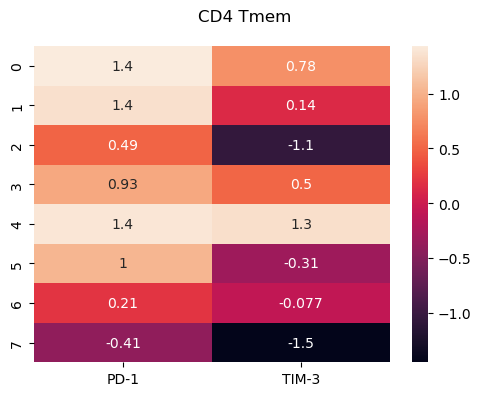

In [41]:
means=plot_heatmap(best_gmm, celltype,['PD-1','TIM-3'])

In [42]:
cluster_map={0: 'CD4 Tex', 4: 'CD4 Tex'}
adata=update_labels(adata_tmp,adata, cluster_map, obs_col='medium_cell_type')
del adata_tmp
gc.collect()
time.sleep(1)

#### CD8 T cells exhausted

In [43]:
celltype='CD8 Tmem'
best_gmm,adata_tmp=cluster_cells(adata,celltype,['Granzyme_B','PD-1','TIM-3'],column='medium_cell_type')

In [44]:
thresholds={}
for gene in ['Granzyme_B','PD-1','TIM-3']:
    thresholds[gene]=set_thresholds(adata_tmp,gene)

In [45]:
thresholds

{'Granzyme_B': {'high': 3.1734479367998736, 'low': 0.6559145460642275},
 'PD-1': {'high': 1.4435284001838529, 'low': 0.26147211738550613},
 'TIM-3': {'high': 0.8982808848317729, 'low': -0.1827182656352931}}

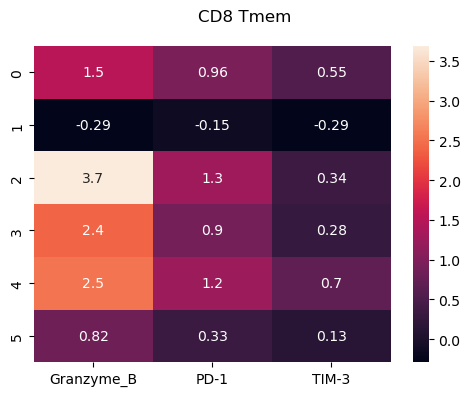

In [46]:
means=plot_heatmap(best_gmm, celltype,['Granzyme_B','PD-1','TIM-3'])

In [47]:
cluster_map={2: 'CD8 GZMB+ Tmem',
             3: 'CD8 GZMB+ Tmem',
             4: 'CD8 Tex'}
adata=update_labels(adata_tmp,adata, cluster_map, obs_col='medium_cell_type')
del adata_tmp
gc.collect()
time.sleep(1)

In [48]:
dict_map={'CD4 Th17':'Th17 CD4 Tmem',
          'CD4 Tcm':'Non Th17 CD4 Tmem',
          'CD4 Tem':'Non Th17 CD4 Tmem',
          'CD4 Temra':'Non Th17 CD4 Tmem',
          'CD4 Tunspecified':'Non Th17 CD4 Tmem',
          'CD4 Treg' : 'Treg',
          'CD8 Tem-GZMB':'CD8 Tmem',
          'CD8 Temra-GZMB':'CD8 Tmem',
          'CD8 Tcm':'CD8 Tmem',
          'CD8 Tem':'CD8 Tmem',
          'CD8 Temra':'CD8 Tmem',
         }
adata.obs['minor_cell_type']=adata.obs['minor_cell_type'].replace(dict_map)
adata.obs['functional_minor_cell_type']=adata.obs['functional_minor_cell_type'].replace(dict_map)

In [49]:
# Transfer labels for Tex and GZMB+ Tmem
adata.obs.loc[adata.obs['medium_cell_type'] == 'CD4 Tex', 'minor_cell_type'] = adata.obs.loc[adata.obs['medium_cell_type'] == 'CD4 Tex', 'medium_cell_type']
adata.obs.loc[adata.obs['medium_cell_type'] == 'CD8 Tex', 'minor_cell_type'] = adata.obs.loc[adata.obs['medium_cell_type'] == 'CD8 Tex', 'medium_cell_type']
adata.obs.loc[adata.obs['medium_cell_type'] == 'CD8 GZMB+ Tmem', 'minor_cell_type'] = adata.obs.loc[adata.obs['medium_cell_type'] == 'CD8 GZMB+ Tmem', 'medium_cell_type']

# same story for functional minor cell types
# Transfer labels for Tex and GZMB+ Tmem
adata.obs.loc[adata.obs['medium_cell_type'] == 'CD4 Tex', 'functional_minor_cell_type'] = adata.obs.loc[adata.obs['medium_cell_type'] == 'CD4 Tex', 'medium_cell_type']
adata.obs.loc[adata.obs['medium_cell_type'] == 'CD8 Tex', 'functional_minor_cell_type'] = adata.obs.loc[adata.obs['medium_cell_type'] == 'CD8 Tex', 'medium_cell_type']
adata.obs.loc[adata.obs['medium_cell_type'] == 'CD8 GZMB+ Tmem', 'functional_minor_cell_type'] = adata.obs.loc[adata.obs['medium_cell_type'] == 'CD8 GZMB+ Tmem', 'medium_cell_type']


### pSTAT1 T cells
#### CD8 Tmem

In [50]:
celltype='CD8 Tmem'
best_gmm,adata_tmp=cluster_cells(adata,celltype,['pSTAT1'])

In [51]:
thresholds={}
gene='pSTAT1'
thresholds[gene]=set_thresholds(adata_tmp,gene)

In [52]:
thresholds

{'pSTAT1': {'high': 1.9006877910631252, 'low': 0.7273339804368995}}

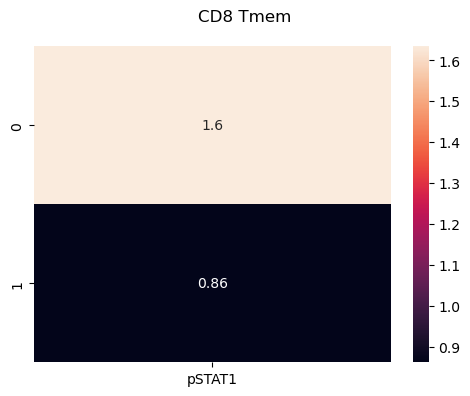

In [53]:
means=plot_heatmap(best_gmm, celltype,[gene])

In [54]:
cluster_map={0: 'pSTAT1+ CD8 Tmem', 1: 'pSTAT1- CD8 Tmem'}

In [55]:
adata=update_labels(adata_tmp,adata, cluster_map, obs_col='functional_minor_cell_type')
del adata_tmp
gc.collect()
time.sleep(1)

#### CD8 GZMB+ Tmem

In [56]:
celltype='CD8 GZMB+ Tmem'
best_gmm,adata_tmp=cluster_cells(adata,celltype,['pSTAT1'])

In [57]:
thresholds={}
gene='pSTAT1'
thresholds[gene]=set_thresholds(adata_tmp,gene)

In [58]:
thresholds

{'pSTAT1': {'high': 2.1104235878449824, 'low': 1.117191852668309}}

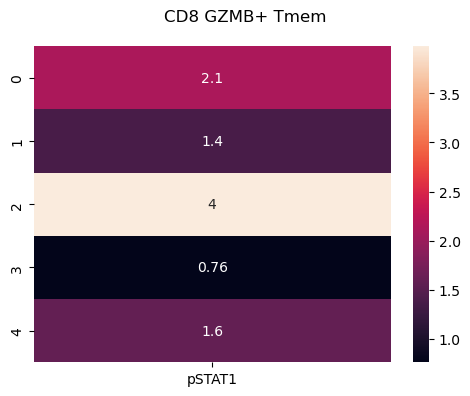

In [59]:
means=plot_heatmap(best_gmm, celltype,[gene])

In [60]:
cluster_map={0: 'pSTAT1+ CD8 GZMB+ Tmem', 
             1: 'pSTAT1- CD8 GZMB+ Tmem',
             2: 'pSTAT1+ CD8 GZMB+ Tmem',
             3: 'pSTAT1- CD8 GZMB+ Tmem',
             4: 'pSTAT1- CD8 GZMB+ Tmem'}

In [61]:
adata=update_labels(adata_tmp,adata, cluster_map, obs_col='functional_minor_cell_type')
del adata_tmp
gc.collect()
time.sleep(1)

#### CD4 Tmem

In [62]:
celltype='CD4 Tmem'
best_gmm,adata_tmp=cluster_cells(adata,celltype,['pSTAT1'],column='medium_cell_type')

In [63]:
thresholds={}
gene='pSTAT1'
thresholds[gene]=set_thresholds(adata_tmp,gene)

In [64]:
thresholds

{'pSTAT1': {'high': 2.3832143057018964, 'low': 1.2194177856478385}}

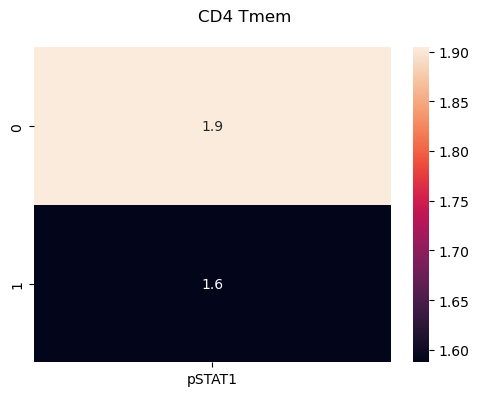

In [65]:
means=plot_heatmap(best_gmm, celltype,[gene])

In [66]:
cluster_map={0: 'pSTAT1+ CD4 Tmem', 
             1: 'pSTAT1- CD4 Tmem'}

In [67]:
adata=update_labels(adata_tmp,adata, cluster_map, obs_col='functional_minor_cell_type')
del adata_tmp
gc.collect()
time.sleep(1)

In [68]:
adata.obs['major_cell_type'].unique()

array(['Myeloid', 'ECs', 'B-T', 'T', 'Unclassified', 'Myeloma', 'B cells',
       'MKs', 'Artifact', 'NK cells'], dtype=object)

In [69]:
adata.obs['medium_cell_type'].unique()

array(['Monocytes', 'ECs', 'M2-like M$\\phi$', 'MDSCs', 'B-T', 'CD4 Tmem',
       'Unclassified', 'Myeloma', 'Treg', 'B cells', 'MKs', 'Tnaive',
       'Artifact', 'NK cells', 'Other T', 'CD8 Tmem', 'CD8 GZMB+ Tmem',
       'CD4 Tex', 'CD8 Tex', 'M1-like M$\\phi$', 'MoDC'], dtype=object)

In [70]:
adata.obs['minor_cell_type'].unique()

array(['Classical monocytes', 'ECs', 'M2-like M$\\phi$', 'MDSCs', 'B-T',
       'Nonclassical monocytes', 'Non Th17 CD4 Tmem', 'Unclassified',
       'Myeloma', 'Treg', 'B cells', 'MKs', 'Th17 CD4 Tmem',
       'Intermediate monocytes', 'CD4 Tnaive', 'Artifact', 'CD56 dim NK',
       'T lineage', 'CD8 Tnaive', 'CD8 Tmem', 'CD8 GZMB+ Tmem', 'CD4 Tex',
       'CD56 bright NK', 'CD8 Tex', 'M1-like M$\\phi$', 'MBCs', 'MoDC'],
      dtype=object)

In [71]:
adata.obs['functional_minor_cell_type'].unique()

array(['Classical monocytes', 'ECs', 'M2-like M$\\phi$', 'MDSCs', 'B-T',
       'Nonclassical monocytes', 'pSTAT1- CD4 Tmem', 'Unclassified',
       'pSTAT1+ CD4 Tmem', 'Myeloma', 'Treg', 'B cells', 'MKs',
       'Intermediate monocytes', 'CD4 Tnaive', 'Artifact',
       'pSTAT1- CD56 dim NK', 'T lineage', 'CD8 Tnaive',
       'pSTAT1+ CD8 Tmem', 'pSTAT1- CD8 GZMB+ Tmem', 'CD4 Tex',
       'pSTAT1- CD56 bright NK', 'pSTAT1- CD8 Tmem',
       'pSTAT1+ CD8 GZMB+ Tmem', 'pSTAT1+ CD56 bright NK', 'CD8 Tex',
       'M1-like M$\\phi$', 'MBCs', 'MoDC', 'Ki-67+ Myeloma',
       'pSTAT1+ CD56 dim NK', 'PD-L1+ Myeloma'], dtype=object)

In [72]:
adata.write('../data/non_denoised/spe_final.h5ad')

In [73]:
adata=adata[~adata.obs['minor_cell_type'].isin(['Unclassified','B-T','Artifact','T lineage'])]

## Plot cell compositions

In [74]:
def plot_props(adata,column):
    df=adata.obs[['library_id',column,'timepoint']].groupby('library_id').value_counts().reset_index()
    counts=df.groupby('library_id').sum('count').reset_index()
    counts.columns=['library_id','total_counts']
    df=df.merge(counts,on='library_id')
    df['Props']=df['count']/df['total_counts']
    plt.figure()
    sns.barplot(data=df,x=column,y='Props')
    plt.xticks(rotation=45,ha='right')
    plt.show()

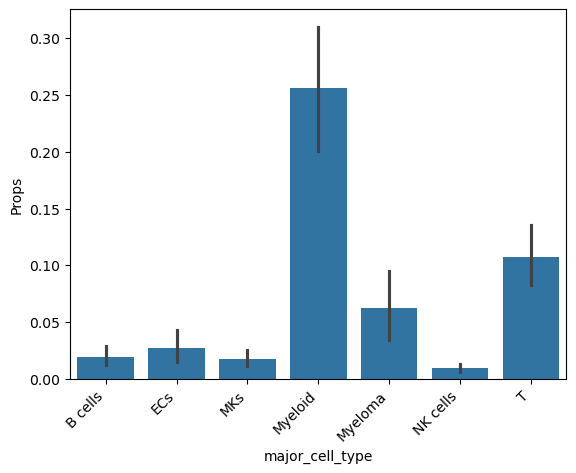

In [75]:
plot_props(adata,'major_cell_type')

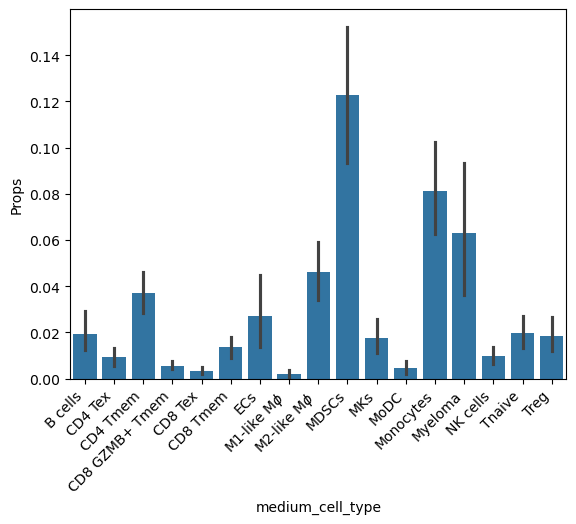

In [76]:
plot_props(adata,'medium_cell_type')

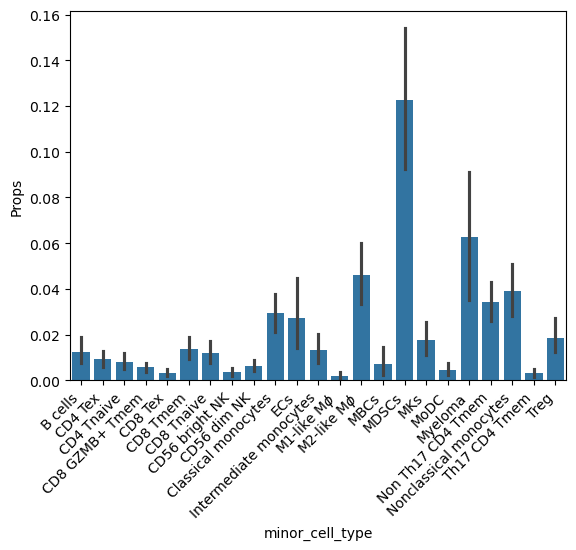

In [77]:
plot_props(adata,'minor_cell_type')

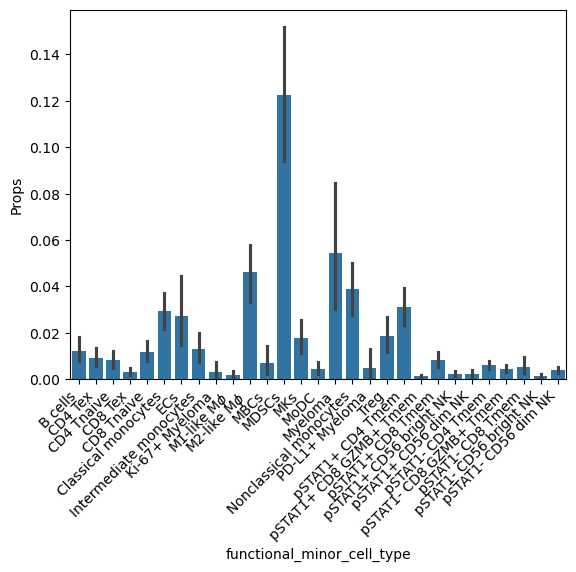

In [78]:
plot_props(adata,'functional_minor_cell_type')